In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
from PIL import Image
from tqdm import tqdm


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torchvision 
from torchvision import models, transforms
 

from torch.utils.data import Dataset, DataLoader


In [2]:
# project_dir     = '/Users/kaheichoi/git_repo/csiro_biomass'
project_dir     = '/Users/k.choi/Documents/github/csiro_git'
data_dir        = os.path.join(project_dir, 'data')
train_df        = pd.read_csv(os.path.join(data_dir, 'train.csv'))

In [3]:
def data_preprocess(df, target_names = ['Dry_Clover_g', 'Dry_Green_g', 'Dry_Dead_g', 'Dry_Total_g', 'GDM_g']):
    data= []
    unique_path = df['image_path'].unique()
    print(f"number of unique path: {unique_path.shape}")

    for img_path in unique_path:
        path_data = df[df['image_path']==img_path]
        row       = {'img_path': img_path}

        for tar in target_names:
            target_row = path_data[ path_data['target_name'] == tar ]
            if len(target_row)>0:
                row[tar] = target_row['target'].values[0]
            else:
                row[tar] = 0

        data.append(row)

    return pd.DataFrame(data)

data = data_preprocess(train_df)
data.info()
display(data.head())

assert data['img_path'].duplicated().sum() == 0

number of unique path: (357,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img_path      357 non-null    object 
 1   Dry_Clover_g  357 non-null    float64
 2   Dry_Green_g   357 non-null    float64
 3   Dry_Dead_g    357 non-null    float64
 4   Dry_Total_g   357 non-null    float64
 5   GDM_g         357 non-null    float64
dtypes: float64(5), object(1)
memory usage: 16.9+ KB


,img_path,Dry_Clover_g,Dry_Green_g,Dry_Dead_g,Dry_Total_g,GDM_g
0,train/ID1011485656.jpg,0.0000,16.2751,31.9984,48.2735,16.2750
1,train/ID1012260530.jpg,0.0000,7.6000,0.0000,7.6000,7.6000
2,train/ID1025234388.jpg,6.0500,0.0000,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,0.0000,24.2376,30.9703,55.2079,24.2376
4,train/ID1035947949.jpg,0.4343,10.5261,23.2239,34.1844,10.9605


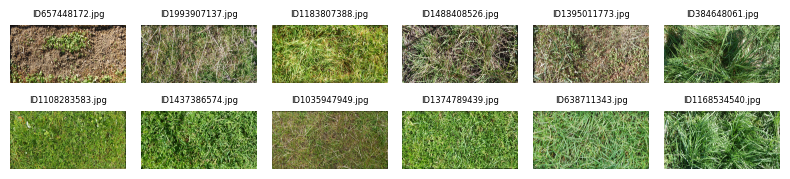

In [4]:
fig, axes = plt.subplots(2, 6, figsize=(8, 2)); axes = axes.flatten()

rand_sample = np.random.choice(len(data), 32, replace=False)

for i , ax in enumerate(axes): 
    img = Image.open(  os.path.join(data_dir, data.iloc[rand_sample[i]]['img_path']) )
    ax.imshow(img)
    ax.set_title(data.iloc[rand_sample[i]]['img_path'].split('/')[-1],fontsize = 6)
    ax.axis('off')

plt.tight_layout();plt.show()

In [5]:
train_data , valid_data = train_test_split(data, test_size=0.2, random_state=8964)
train_data , test_data  = train_test_split(train_data, test_size=0.1, random_state=8964)

In [6]:
def compute_img_mean_std(df, data_dir):

    means = np.zeros(3)
    stds = np.zeros(3)
    counts = 0

    for img_id in tqdm(df['img_path'], desc = 'Calculating mean and std'):
        img = Image.open(os.path.join(data_dir, img_id))
        img = img.convert('RGB')
        arr = np.array(img)/255.0

        arr = arr.reshape(-1,3)

        means += arr.mean(axis=0)
        stds += arr.std(axis=0)

        counts +=1 

    mean_val = means/counts ;print(mean_val)
    std_val = stds/counts ;print(std_val)

    return mean_val, std_val


resnet50_pretrained = True

if resnet50_pretrained:
    mean , std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
else:
    mean, std = compute_img_mean_std(train_data, data_dir)
    assert mean.shape == (3,) and std.shape == (3,) and mean.all() > 0 and std.all() > 0

print(f"mean: {mean}, std: {std}")

mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225]


In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation([-15,15], fill=0),
    # torchvision.transforms.GaussianBlur(1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


In [8]:
class BiomassDS(Dataset):

    def __init__(self, df, transform, data_dir, target_names = ['Dry_Clover_g', 'Dry_Green_g', 'Dry_Dead_g', 'Dry_Total_g', 'GDM_g']):

        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform
        self.target_names = target_names

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        img_path = os.path.join(self.data_dir, row['img_path'])
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        targets = torch.tensor( [ row[tar] for tar in self.target_names ], dtype=torch.float32)

        return img, targets

train_ds = BiomassDS(df= train_data, transform= train_transform, data_dir= data_dir); print(f"train_ds length: {len(train_ds)}")
valid_ds = BiomassDS(df= valid_data, transform= valid_transform, data_dir= data_dir); print(f"valid_ds length: {len(valid_ds)}")

sample_img, sample_target = train_ds[0]
assert sample_img.shape == torch.Size([3, 224, 224]) and sample_target.shape == torch.Size([5])

sample_img, sample_target = valid_ds[0]
assert sample_img.shape == torch.Size([3, 224, 224]) and sample_target.shape == torch.Size([5])



train_ds length: 256
valid_ds length: 72


In [9]:
batch_size = 16
slaves = 0

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=slaves, pin_memory=False); print(f"train_loader length: {len(train_loader)}")
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=slaves, pin_memory=False); print(f"valid_loader length: {len(valid_loader)}")

for imgs,tars in train_loader:
    assert imgs.shape == torch.Size([batch_size, 3, 224, 224]) and tars.shape == torch.Size([batch_size, 5])
    break

for imgs,tars in valid_loader:
    assert imgs.shape == torch.Size([batch_size, 3, 224, 224]) and tars.shape == torch.Size([batch_size, 5])
    break

train_loader length: 16
valid_loader length: 5


In [12]:
class get_baselineCNN(nn.Module):

    def __init__(self, n_outputs = 5):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_outputs)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.regressor(x)
        return x


class get_resnet50(nn.Module):

    def __init__(self, n_outputs = 5):
        super().__init__()
 
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT )
        for param in self.backbone.parameters():
            param.requires_grad = False
 
        in_features = self.backbone.fc.in_features

        # self.backbone.fc = nn.Linear(in_features, n_outputs)
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 16),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(16, n_outputs)
        )

    def forward(self, x):
        return self.backbone(x)

In [13]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# model = get_baselineCNN().to(device)
model = get_resnet50().to(device)

x = torch.randn(16, 3, 224, 224).to(device)
y = model(x); assert y.shape == torch.Size([16, 5])

In [14]:
learning_rate = 1e-2
num_epochs = 150
weight_decay = 1e-4
patience = 12

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)
criteron  = nn.MSELoss()

In [15]:
from sklearn.metrics import mean_squared_error

history =  {'train_loss': [], 'valid_loss': [], 'val_rmse': [], 'learning_rate': []}
best_val = float('inf')
epoch_counter = 0
model_dir = os.path.join(project_dir, 'models'); os.makedirs(model_dir, exist_ok=True)
ii = 0

for epoch in range(num_epochs):

    """ training """
    model.train()
    train_loss = 0
    n_train = 0

    pbar = tqdm(train_loader, desc = f"Epoch {epoch+1}/{num_epochs} training")
    for imgs, tars in pbar:
        imgs, tars = imgs.to(device), tars.to(device)
        
        optimizer.zero_grad()
        preds = model(imgs)

        loss  = criteron(preds, tars)
        
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        train_loss += loss.item() * batch_size
        n_train += batch_size 

    train_loss = train_loss / n_train

    """ validation """
    valid_loss = 0
    n_valid = 0
    pred_list, targ_list = [], []

    model.eval()
    with torch.no_grad():
        pbar = tqdm(valid_loader, desc = f"Epoch {epoch+1}/{num_epochs} validation")
        for imgs, tars in pbar:
            imgs, tars = imgs.to(device), tars.to(device)

            preds = model(imgs)
            loss = criteron(preds, tars)

            batch_size = imgs.size(0)
            valid_loss += loss.item() * batch_size
            n_valid += batch_size

            pred_list.append(preds.cpu())
            targ_list.append(tars.cpu())

    valid_loss = valid_loss / n_valid

    """ evaluate mse """
    all_preds = torch.cat(pred_list, dim=0).numpy()
    all_targs = torch.cat(targ_list, dim=0).numpy()

    mse = mean_squared_error(all_targs, all_preds)
    rmser = np.sqrt(mse) 

    """ update learning rate """
    scheduler.step(valid_loss)
    current_lr = optimizer.param_groups[0]['lr']

    """ update history """
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['val_rmse'].append(rmser)
    history['learning_rate'].append(current_lr)


    print(f"train loss: {train_loss:.4f}")
    print(f"valid loss: {valid_loss:.4f}")
    print(f"rmse: {rmser:.4f}")
    print(f"mse: {mse:.4f}")
    print(f"lr: {current_lr:.6f}")
    per_target_rmse = np.sqrt(np.mean((all_preds - all_targs)**2, axis=0))
    print(f"per target rmse: {per_target_rmse}")

    ii += 1

    """ save best model """
    if valid_loss < best_val:
        print(f"valid loss improved from: {best_val:.4f} to {valid_loss:.4f} with rmse: {rmser:.4f}")
        best_val = valid_loss
        epoch_counter = 0
        torch.save(model.state_dict(), os.path.join(model_dir, f'best_model.pth'))
        best_model = model.state_dict()
        print(f"best model saved")

    else:
        epoch_counter += 1
        print(f"valid loss did not improve from: {best_val:.4f}")

    """ early stopping """
    if epoch_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break


Epoch 1/150 training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


train loss: 1073.0476
valid loss: 717.5531
rmse: 26.7872
mse: 717.5531
lr: 0.010000
per target rmse: [ 8.209906 24.965303 16.57326  38.839493 33.3754  ]
valid loss improved from: inf to 717.5531 with rmse: 26.7872
best model saved


Epoch 2/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


train loss: 634.9827
valid loss: 477.5432
rmse: 21.8528
mse: 477.5432
lr: 0.010000
per target rmse: [ 7.92376  23.275616 16.842787 30.648172 23.668243]
valid loss improved from: 717.5531 to 477.5432 with rmse: 21.8528
best model saved


Epoch 3/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


train loss: 610.9815
valid loss: 419.1604
rmse: 20.4734
mse: 419.1603
lr: 0.010000
per target rmse: [ 7.9284444 21.875671  15.399089  28.747166  22.155476 ]
valid loss improved from: 477.5432 to 419.1604 with rmse: 20.4734
best model saved


Epoch 4/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


train loss: 484.9480
valid loss: 368.1999
rmse: 19.1885
mse: 368.1999
lr: 0.010000
per target rmse: [ 7.9732027 19.976408  15.938533  26.481638  20.568344 ]
valid loss improved from: 419.1604 to 368.1999 with rmse: 19.1885
best model saved


Epoch 5/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


train loss: 477.5205
valid loss: 353.5314
rmse: 18.8024
mse: 353.5314
lr: 0.010000
per target rmse: [ 8.221446 19.972492 14.838822 25.765045 20.423916]
valid loss improved from: 368.1999 to 353.5314 with rmse: 18.8024
best model saved


Epoch 6/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


train loss: 489.4011
valid loss: 357.3698
rmse: 18.9042
mse: 357.3698
lr: 0.010000
per target rmse: [ 8.168588 19.368353 15.972456 26.327436 19.918251]
valid loss did not improve from: 353.5314


Epoch 7/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


train loss: 413.5290
valid loss: 329.3016
rmse: 18.1467
mse: 329.3015
lr: 0.010000
per target rmse: [ 8.221116 18.435465 15.32677  25.219116 19.187   ]
valid loss improved from: 353.5314 to 329.3016 with rmse: 18.1467
best model saved


Epoch 8/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


train loss: 424.4165
valid loss: 315.0369
rmse: 17.7493
mse: 315.0369
lr: 0.010000
per target rmse: [ 8.159799 18.091179 15.099165 24.406813 18.911217]
valid loss improved from: 329.3016 to 315.0369 with rmse: 17.7493
best model saved


Epoch 9/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


train loss: 424.8753
valid loss: 305.6176
rmse: 17.4819
mse: 305.6176
lr: 0.010000
per target rmse: [ 8.218221 17.698214 15.362541 23.754915 18.628428]
valid loss improved from: 315.0369 to 305.6176 with rmse: 17.4819
best model saved


Epoch 10/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


train loss: 418.5345
valid loss: 307.4733
rmse: 17.5349
mse: 307.4732
lr: 0.010000
per target rmse: [ 8.3962345 17.493252  15.392587  24.282434  18.283525 ]
valid loss did not improve from: 305.6176


Epoch 11/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


train loss: 426.5187
valid loss: 286.8060
rmse: 16.9353
mse: 286.8059
lr: 0.010000
per target rmse: [ 8.166218 17.244947 14.790235 23.015818 17.929737]
valid loss improved from: 305.6176 to 286.8060 with rmse: 16.9353
best model saved


Epoch 12/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


train loss: 403.3068
valid loss: 291.2751
rmse: 17.0668
mse: 291.2751
lr: 0.010000
per target rmse: [ 8.135949 17.36442  15.044021 23.190952 18.01433 ]
valid loss did not improve from: 286.8060


Epoch 13/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


train loss: 365.2281
valid loss: 282.0354
rmse: 16.7939
mse: 282.0355
lr: 0.010000
per target rmse: [ 8.173825 16.728243 15.186651 23.067448 17.34331 ]
valid loss improved from: 286.8060 to 282.0354 with rmse: 16.7939
best model saved


Epoch 14/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


train loss: 393.9241
valid loss: 293.5015
rmse: 17.1319
mse: 293.5015
lr: 0.010000
per target rmse: [ 8.024679 16.907074 15.643111 23.8135   17.477793]
valid loss did not improve from: 282.0354


Epoch 15/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


train loss: 398.9245
valid loss: 281.5527
rmse: 16.7795
mse: 281.5527
lr: 0.010000
per target rmse: [ 7.9807444 17.289364  14.54465   22.396582  18.220745 ]
valid loss improved from: 282.0354 to 281.5527 with rmse: 16.7795
best model saved


Epoch 16/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


train loss: 340.9331
valid loss: 273.0116
rmse: 16.5231
mse: 273.0115
lr: 0.010000
per target rmse: [ 7.927757 16.697914 14.942134 22.355427 17.33077 ]
valid loss improved from: 281.5527 to 273.0116 with rmse: 16.5231
best model saved


Epoch 17/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


train loss: 361.9651
valid loss: 267.3380
rmse: 16.3505
mse: 267.3380
lr: 0.010000
per target rmse: [ 8.017716 16.479893 14.976685 21.960707 17.15359 ]
valid loss improved from: 273.0116 to 267.3380 with rmse: 16.3505
best model saved


Epoch 18/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


train loss: 342.9337
valid loss: 272.1661
rmse: 16.4975
mse: 272.1661
lr: 0.010000
per target rmse: [ 7.843868 16.840324 15.099459 22.071793 17.336372]
valid loss did not improve from: 267.3380


Epoch 19/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


train loss: 391.1492
valid loss: 258.0993
rmse: 16.0655
mse: 258.0993
lr: 0.010000
per target rmse: [ 8.018457 15.875068 14.891081 22.044052 16.32478 ]
valid loss improved from: 267.3380 to 258.0993 with rmse: 16.0655
best model saved


Epoch 20/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


train loss: 357.0232
valid loss: 258.8521
rmse: 16.0889
mse: 258.8521
lr: 0.010000
per target rmse: [ 7.851783 15.883197 15.139794 22.002266 16.340767]
valid loss did not improve from: 258.0993


Epoch 21/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


train loss: 341.6420
valid loss: 253.0721
rmse: 15.9082
mse: 253.0721
lr: 0.010000
per target rmse: [ 7.8738236 15.729826  14.810979  21.756596  16.224102 ]
valid loss improved from: 258.0993 to 253.0721 with rmse: 15.9082
best model saved


Epoch 22/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


train loss: 375.5267
valid loss: 246.0663
rmse: 15.6865
mse: 246.0663
lr: 0.010000
per target rmse: [ 7.881175 15.304872 14.961324 21.393686 15.888629]
valid loss improved from: 253.0721 to 246.0663 with rmse: 15.6865
best model saved


Epoch 23/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


train loss: 325.5442
valid loss: 248.2977
rmse: 15.7575
mse: 248.2977
lr: 0.010000
per target rmse: [ 8.16298   15.5845785 14.662757  21.165052  16.401802 ]
valid loss did not improve from: 246.0663


Epoch 24/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


train loss: 337.5182
valid loss: 252.3307
rmse: 15.8849
mse: 252.3307
lr: 0.010000
per target rmse: [ 7.8445425 15.90694   14.6421995 21.12992   16.917982 ]
valid loss did not improve from: 246.0663


Epoch 25/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


train loss: 290.9649
valid loss: 262.1347
rmse: 16.1906
mse: 262.1347
lr: 0.010000
per target rmse: [ 7.989439 16.502981 14.447146 21.526146 17.389622]
valid loss did not improve from: 246.0663


Epoch 26/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


train loss: 368.6670
valid loss: 238.3709
rmse: 15.4393
mse: 238.3709
lr: 0.010000
per target rmse: [ 8.27463  15.036473 14.456014 20.964794 15.773097]
valid loss improved from: 246.0663 to 238.3709 with rmse: 15.4393
best model saved


Epoch 27/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


train loss: 365.7646
valid loss: 245.5753
rmse: 15.6708
mse: 245.5753
lr: 0.010000
per target rmse: [ 7.7381964 15.051713  15.087512  21.67947   15.614431 ]
valid loss did not improve from: 238.3709


Epoch 28/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


train loss: 338.9114
valid loss: 239.2749
rmse: 15.4685
mse: 239.2749
lr: 0.010000
per target rmse: [ 7.7067237 15.121393  14.848908  20.956604  15.768798 ]
valid loss did not improve from: 238.3709


Epoch 29/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


train loss: 306.3285
valid loss: 233.6609
rmse: 15.2860
mse: 233.6609
lr: 0.010000
per target rmse: [ 7.840667  14.514924  14.7638855 20.923332  15.504431 ]
valid loss improved from: 238.3709 to 233.6609 with rmse: 15.2860
best model saved


Epoch 30/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


train loss: 366.6845
valid loss: 233.4201
rmse: 15.2781
mse: 233.4201
lr: 0.010000
per target rmse: [ 7.6907744 14.992311  14.312669  20.598305  15.938645 ]
valid loss improved from: 233.6609 to 233.4201 with rmse: 15.2781
best model saved


Epoch 31/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


train loss: 326.8243
valid loss: 251.0233
rmse: 15.8437
mse: 251.0233
lr: 0.010000
per target rmse: [ 7.9771795 15.958172  14.469027  20.896088  17.053411 ]
valid loss did not improve from: 233.4201


Epoch 32/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


train loss: 348.6156
valid loss: 225.2597
rmse: 15.0087
mse: 225.2597
lr: 0.010000
per target rmse: [ 7.873286  14.345702  14.6113205 20.373796  15.163386 ]
valid loss improved from: 233.4201 to 225.2597 with rmse: 15.0087
best model saved


Epoch 33/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


train loss: 277.9631
valid loss: 247.2756
rmse: 15.7250
mse: 247.2755
lr: 0.010000
per target rmse: [ 7.785359  15.652051  14.2502165 20.746809  17.24182  ]
valid loss did not improve from: 225.2597


Epoch 34/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


train loss: 279.0736
valid loss: 230.0815
rmse: 15.1684
mse: 230.0815
lr: 0.010000
per target rmse: [ 7.741044 14.486504 14.592317 20.720322 15.438837]
valid loss did not improve from: 225.2597


Epoch 35/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


train loss: 290.3215
valid loss: 234.2918
rmse: 15.3066
mse: 234.2918
lr: 0.010000
per target rmse: [ 8.105766 14.886243 14.241644 20.422762 16.255516]
valid loss did not improve from: 225.2597


Epoch 36/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


train loss: 287.8820
valid loss: 225.2528
rmse: 15.0084
mse: 225.2528
lr: 0.010000
per target rmse: [ 7.7971306 13.995772  14.696539  20.587297  15.157901 ]
valid loss improved from: 225.2597 to 225.2528 with rmse: 15.0084
best model saved


Epoch 37/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


train loss: 319.6326
valid loss: 231.9189
rmse: 15.2289
mse: 231.9189
lr: 0.010000
per target rmse: [ 7.735997 14.814608 14.36707  20.538712 15.87529 ]
valid loss did not improve from: 225.2528


Epoch 38/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


train loss: 330.6236
valid loss: 224.3229
rmse: 14.9774
mse: 224.3229
lr: 0.010000
per target rmse: [ 7.7355046 14.344205  14.317087  20.300924  15.45683  ]
valid loss improved from: 225.2528 to 224.3229 with rmse: 14.9774
best model saved


Epoch 39/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


train loss: 343.0654
valid loss: 230.3116
rmse: 15.1760
mse: 230.3116
lr: 0.010000
per target rmse: [ 7.645099 14.508004 14.53934  20.712418 15.563799]
valid loss did not improve from: 224.3229


Epoch 40/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


train loss: 281.8649
valid loss: 218.6649
rmse: 14.7873
mse: 218.6649
lr: 0.010000
per target rmse: [ 7.9066486 14.084156  14.211285  20.106596  15.040287 ]
valid loss improved from: 224.3229 to 218.6649 with rmse: 14.7873
best model saved


Epoch 41/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


train loss: 328.0215
valid loss: 234.0424
rmse: 15.2984
mse: 234.0424
lr: 0.010000
per target rmse: [ 7.9556513 14.287179  14.734243  21.48232   14.973584 ]
valid loss did not improve from: 218.6649


Epoch 42/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


train loss: 306.4205
valid loss: 227.8938
rmse: 15.0962
mse: 227.8938
lr: 0.010000
per target rmse: [ 7.650601 14.45895  13.951455 20.554438 15.960828]
valid loss did not improve from: 218.6649


Epoch 43/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


train loss: 293.3715
valid loss: 227.9211
rmse: 15.0971
mse: 227.9211
lr: 0.010000
per target rmse: [ 7.85324   14.066291  14.8710375 20.869505  14.946162 ]
valid loss did not improve from: 218.6649


Epoch 44/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


train loss: 300.9513
valid loss: 228.0967
rmse: 15.1029
mse: 228.0967
lr: 0.010000
per target rmse: [ 7.527931 14.074828 14.483723 21.159706 15.106343]
valid loss did not improve from: 218.6649


Epoch 45/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


train loss: 303.2866
valid loss: 223.5757
rmse: 14.9524
mse: 223.5757
lr: 0.010000
per target rmse: [ 7.4920077 13.870262  14.236851  21.0487    14.954204 ]
valid loss did not improve from: 218.6649


Epoch 46/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


train loss: 344.4953
valid loss: 239.9696
rmse: 15.4910
mse: 239.9696
lr: 0.005000
per target rmse: [ 7.5553026 14.340288  14.851262  21.87873   15.42344  ]
valid loss did not improve from: 218.6649


Epoch 47/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


train loss: 318.8569
valid loss: 217.4178
rmse: 14.7451
mse: 217.4178
lr: 0.005000
per target rmse: [ 7.812304 13.788527 14.288208 20.092094 15.102593]
valid loss improved from: 218.6649 to 217.4178 with rmse: 14.7451
best model saved


Epoch 48/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


train loss: 262.1951
valid loss: 214.4482
rmse: 14.6441
mse: 214.4482
lr: 0.005000
per target rmse: [ 7.532757 13.950872 14.128027 19.780788 15.165458]
valid loss improved from: 217.4178 to 214.4482 with rmse: 14.6441
best model saved


Epoch 49/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


train loss: 305.6187
valid loss: 211.1899
rmse: 14.5324
mse: 211.1899
lr: 0.005000
per target rmse: [ 7.6800747 13.652899  14.246138  19.708239  14.805311 ]
valid loss improved from: 214.4482 to 211.1899 with rmse: 14.5324
best model saved


Epoch 50/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


train loss: 308.2916
valid loss: 214.6664
rmse: 14.6515
mse: 214.6664
lr: 0.005000
per target rmse: [ 7.5926476 13.764217  14.444619  19.942665  14.828122 ]
valid loss did not improve from: 211.1899


Epoch 51/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


train loss: 300.4768
valid loss: 204.8285
rmse: 14.3118
mse: 204.8284
lr: 0.005000
per target rmse: [ 7.584592 13.567301 14.149191 19.263866 14.534386]
valid loss improved from: 211.1899 to 204.8285 with rmse: 14.3118
best model saved


Epoch 52/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


train loss: 242.5014
valid loss: 211.8085
rmse: 14.5536
mse: 211.8085
lr: 0.005000
per target rmse: [ 7.572154 13.526586 14.402703 20.14366  14.336374]
valid loss did not improve from: 204.8285


Epoch 53/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


train loss: 257.3252
valid loss: 209.6322
rmse: 14.4787
mse: 209.6322
lr: 0.005000
per target rmse: [ 7.657908 13.506508 14.213887 19.755045 14.6559  ]
valid loss did not improve from: 204.8285


Epoch 54/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


train loss: 292.6479
valid loss: 211.2802
rmse: 14.5355
mse: 211.2801
lr: 0.005000
per target rmse: [ 7.7933292 13.569641  14.2581215 19.663897  14.885116 ]
valid loss did not improve from: 204.8285


Epoch 55/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


train loss: 308.3273
valid loss: 203.9788
rmse: 14.2821
mse: 203.9789
lr: 0.005000
per target rmse: [ 7.3830223 13.420983  14.155177  19.462631  14.356164 ]
valid loss improved from: 204.8285 to 203.9788 with rmse: 14.2821
best model saved


Epoch 56/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


train loss: 299.0207
valid loss: 213.0411
rmse: 14.5959
mse: 213.0411
lr: 0.005000
per target rmse: [ 7.5019546 13.737012  14.44845   19.658638  15.000031 ]
valid loss did not improve from: 203.9788


Epoch 57/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


train loss: 262.5207
valid loss: 204.1340
rmse: 14.2875
mse: 204.1340
lr: 0.005000
per target rmse: [ 7.5135307 13.270036  14.223264  19.39981   14.47304  ]
valid loss did not improve from: 203.9788


Epoch 58/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


train loss: 283.9259
valid loss: 208.5125
rmse: 14.4400
mse: 208.5125
lr: 0.005000
per target rmse: [ 7.3932314 13.416235  14.323152  19.779879  14.543411 ]
valid loss did not improve from: 203.9788


Epoch 59/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


train loss: 283.9384
valid loss: 209.1142
rmse: 14.4608
mse: 209.1142
lr: 0.005000
per target rmse: [ 7.5186253 13.4416895 14.061853  19.923813  14.617398 ]
valid loss did not improve from: 203.9788


Epoch 60/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


train loss: 239.4297
valid loss: 207.1256
rmse: 14.3919
mse: 207.1256
lr: 0.005000
per target rmse: [ 7.5863276 13.439596  13.910137  19.511278  14.942249 ]
valid loss did not improve from: 203.9788


Epoch 61/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


train loss: 281.1735
valid loss: 198.8956
rmse: 14.1030
mse: 198.8956
lr: 0.005000
per target rmse: [ 7.4517198 12.963002  14.199454  19.264051  14.077716 ]
valid loss improved from: 203.9788 to 198.8956 with rmse: 14.1030
best model saved


Epoch 62/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


train loss: 264.6026
valid loss: 203.3755
rmse: 14.2610
mse: 203.3755
lr: 0.005000
per target rmse: [ 7.420041 13.523637 13.796717 19.111887 14.943842]
valid loss did not improve from: 198.8956


Epoch 63/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


train loss: 298.7646
valid loss: 209.5250
rmse: 14.4750
mse: 209.5250
lr: 0.005000
per target rmse: [ 7.4926558 13.437698  14.378793  19.637495  14.782843 ]
valid loss did not improve from: 198.8956


Epoch 64/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


train loss: 288.6131
valid loss: 207.6238
rmse: 14.4092
mse: 207.6238
lr: 0.005000
per target rmse: [ 7.418017 13.585297 14.11826  19.50464  14.791058]
valid loss did not improve from: 198.8956


Epoch 65/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


train loss: 270.4868
valid loss: 204.6406
rmse: 14.3053
mse: 204.6406
lr: 0.005000
per target rmse: [ 7.582646  13.2724905 14.221011  19.403433  14.519547 ]
valid loss did not improve from: 198.8956


Epoch 66/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


train loss: 295.5350
valid loss: 205.9132
rmse: 14.3497
mse: 205.9132
lr: 0.005000
per target rmse: [ 7.411774 13.480824 14.035873 19.519863 14.658385]
valid loss did not improve from: 198.8956


Epoch 67/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


train loss: 282.1741
valid loss: 201.0612
rmse: 14.1796
mse: 201.0612
lr: 0.002500
per target rmse: [ 7.464546 13.225001 13.959793 19.303883 14.393418]
valid loss did not improve from: 198.8956


Epoch 68/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


train loss: 271.3467
valid loss: 202.3677
rmse: 14.2256
mse: 202.3677
lr: 0.002500
per target rmse: [ 7.570268 13.278007 13.9292   19.297518 14.553593]
valid loss did not improve from: 198.8956


Epoch 69/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


train loss: 314.8922
valid loss: 199.3247
rmse: 14.1182
mse: 199.3247
lr: 0.002500
per target rmse: [ 7.435853 13.110699 14.011539 19.114254 14.413993]
valid loss did not improve from: 198.8956


Epoch 70/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


train loss: 299.1165
valid loss: 201.6351
rmse: 14.1998
mse: 201.6351
lr: 0.002500
per target rmse: [ 7.5393634 13.005567  14.1966715 19.52263   14.124811 ]
valid loss did not improve from: 198.8956


Epoch 71/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


train loss: 272.8956
valid loss: 204.3839
rmse: 14.2963
mse: 204.3839
lr: 0.002500
per target rmse: [ 7.633297  13.2301235 14.141399  19.355728  14.628487 ]
valid loss did not improve from: 198.8956


Epoch 72/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


train loss: 232.7959
valid loss: 204.3970
rmse: 14.2967
mse: 204.3969
lr: 0.002500
per target rmse: [ 7.462083 13.203453 14.181874 19.748388 14.172035]
valid loss did not improve from: 198.8956


Epoch 73/150 validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

train loss: 268.0433
valid loss: 206.2402
rmse: 14.3611
mse: 206.2402
lr: 0.001250
per target rmse: [ 7.40858  13.472952 14.013253 19.625156 14.60395 ]
valid loss did not improve from: 198.8956
Early stopping at epoch 73


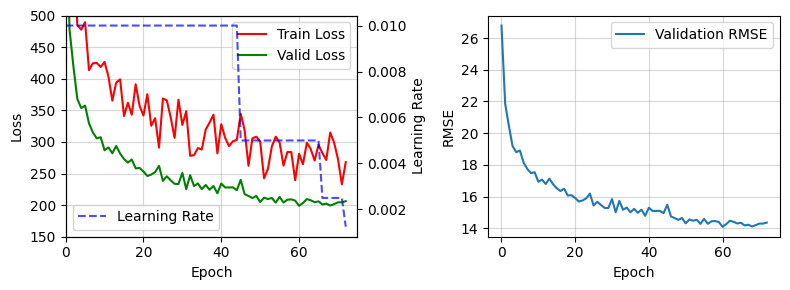

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()

axes[0].plot(history['train_loss'], label='Train Loss', c='r')
axes[0].plot(history['valid_loss'], label='Valid Loss', c='g')
axes[0].legend(loc = 'upper right')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_xlim(0, 75)
axes[0].set_ylim(150, 500)

ax1 = axes[0].twinx()
ax1.plot(history['learning_rate'], label='Learning Rate', c='b', ls='--', alpha=0.7)
ax1.set_ylabel('Learning Rate')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower left')

axes[1].plot(history['val_rmse'], label='Validation RMSE')
axes[1].legend(loc='upper right')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Epoch')
axes[0].grid(True,alpha=0.5)
axes[1].grid(True,alpha=0.5)

plt.tight_layout()
plt.show()


In [43]:
data.describe()

,Dry_Clover_g,Dry_Green_g,Dry_Dead_g,Dry_Total_g,GDM_g
count,357.000000,357.000000,357.000000,357.000000,357.000000
mean,6.649692,26.624722,12.044548,45.318097,33.274414
std,12.117761,25.401232,12.402007,27.984015,24.935822
min,0.000000,0.000000,0.000000,1.040000,1.040000
25%,0.000000,8.800000,3.200000,25.271500,16.026100
50%,1.423500,20.800000,7.980900,40.300000,27.108200
75%,7.242900,35.083400,17.637800,57.880000,43.675700
max,71.786500,157.983600,83.840700,185.700000,157.983600


In [ ]:
per_target_rmse = np.sqrt(np.mean((all_preds - all_targs)**2, axis=0))
print(per_target_rmse)

[ 8.689291 34.754436 14.646674 28.963827 30.987223]
